In [96]:
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import os

In [17]:
def load_bergen_data(years = ['2013','2014','2015']):
    file_name_1 = 'elspot-prices_'
    file_name_2 = '_hourly_dkk.csv'
    data_folder = os.getcwd().replace('notebook','data\\')
    all_data=[]
    for year in years:
        file_name_tot = data_folder + file_name_1 + year + file_name_2
        all_data.append(pd.read_csv(file_name_tot,encoding = "ISO-8859-1",sep=';',decimal=','))
    df = pd.concat(all_data, ignore_index=True,sort= True)
    df = df[['datetime','Hours','Bergen']]
    return df

In [5]:
def generate_shifted_features(df,time_shift,colname):
    pd.options.mode.chained_assignment = None
    df = df[['datetime','Hours','Bergen']]
    for t in time_shift:
        df.loc[:,colname+'_'+str(t)] = df.Bergen.shift(t)
    return df

In [6]:
def create_train_test(df,test_size = 8000):
    df = df.dropna()
    train_size = df.shape[0]-test_size
    
    X_train = df.drop(['Bergen','Hours','datetime'],axis=1).head(train_size)
    y_train = df['Bergen'].head(train_size)
    X_test = df.drop(['Bergen','Hours','datetime'],axis=1).tail(test_size)
    y_test = df['Bergen'].tail(test_size)
    
    return X_train, y_train, X_test, y_test

In [86]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history.iloc[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


## CODE

In [87]:
df = load_bergen_data()

raw_values = df['Bergen'].dropna()

In [88]:
diff_values = difference(raw_values, 1)

In [89]:
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [90]:
test_size = 8000
train_size = len(supervised_values)-test_size
train, test = supervised_values[0:train_size], supervised_values[train_size:]

In [91]:
scaler, train_scaled, test_scaled = scale(train, test)

In [101]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 50, 2)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

Epoch 1/1
18279/18279 [==============================] - 25s 1ms/step - loss: 0.0015
Epoch 1/1
18279/18279 [==============================] - 24s 1ms/step - loss: 0.0014
Epoch 1/1
18279/18279 [==============================] - 24s 1ms/step - loss: 0.0014
Epoch 1/1
18279/18279 [==============================] - 24s 1ms/step - loss: 0.0014
Epoch 1/1
18279/18279 [==============================] - 24s 1ms/step - loss: 0.0014
Epoch 1/1
18279/18279 [==============================] - 24s 1ms/step - loss: 0.0014
Epoch 1/1
18279/18279 [==============================] - 24s 1ms/step - loss: 0.0014
Epoch 1/1
18279/18279 [==============================] - 24s 1ms/step - loss: 0.0014
Epoch 1/1
18279/18279 [==============================] - 24s 1ms/step - loss: 0.0013
Epoch 1/1
18279/18279 [==============================] - 24s 1ms/step - loss: 0.0013
Epoch 1/1
18279/18279 [==============================] - 24s 1ms/step - loss: 0.0013
Epoch 1/1
18279/18279 [==============================] - 24s 1ms/

array([[0.02238812],
       [0.01998907],
       [0.02562597],
       ...,
       [0.0272676 ],
       [0.02596288],
       [0.02862387]], dtype=float32)

## SAMPLE CODE

In [108]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values.iloc[len(train) + i + 1]
    if (i % 1000 == 0):
        print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[train_size+1:], predictions))
mae = mean_absolute_error(raw_values[train_size+1:], predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)


Month=1, Predicted=212.707954, Expected=216.010000
Month=1001, Predicted=181.164779, Expected=181.140000
Month=2001, Predicted=167.447543, Expected=155.700000
Month=3001, Predicted=66.941708, Expected=69.960000
Month=4001, Predicted=58.203264, Expected=58.580000
Month=5001, Predicted=97.987947, Expected=83.590000
Month=6001, Predicted=156.775477, Expected=158.880000
Month=7001, Predicted=216.863781, Expected=222.000000
Test RMSE: 10.599
Test MAE: 4.120


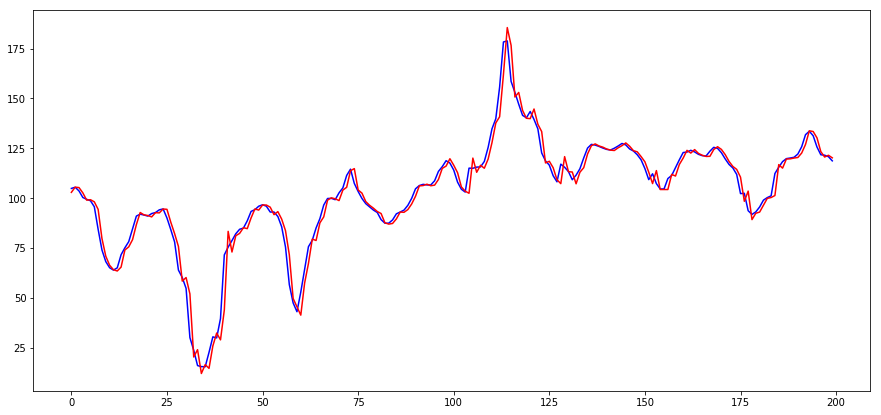

In [114]:
# line plot of observed vs predicted
pyplot.figure(figsize=(15,7))
subset= 200
pyplot.plot(range(subset),raw_values[-subset:],color = 'b')
pyplot.plot(range(subset),predictions[-subset:], color = 'r')
pyplot.show()